In [73]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

In [40]:
import pandas as pd

data = pd.read_csv('/home/louisedantas/code/LouiseDantas/winequalityN.csv')

In [41]:
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [42]:
data.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

# Checking if data is clean

Duplicates

In [43]:
data[data.duplicated()]
duplicate_count=len(data[data.duplicated()])

In [44]:
data=data.drop_duplicates()

Missing Values

In [45]:
data.isnull().sum()/len(data)

type                    0.000000
fixed acidity           0.001877
volatile acidity        0.001501
citric acid             0.000563
residual sugar          0.000375
chlorides               0.000375
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.001689
sulphates               0.000751
alcohol                 0.000000
quality                 0.000000
dtype: float64

In [46]:
data=data.dropna()

# Scaling

Scale numeric features

In [47]:
std_scaler = StandardScaler()
minmaxscaler = MinMaxScaler()

In [48]:
data.loc[:,data.columns != 'type']=minmaxscaler.fit_transform(data.loc[:,data.columns != 'type'])

Scale categorical features

In [49]:
cat_scaler = OneHotEncoder(sparse=False)

In [50]:
cat_scaler.fit(data[['type']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [51]:
type_encoded=cat_scaler.transform(data[['type']])

In [52]:
data['red'],data['white']=type_encoded.T

In [53]:
data=data.drop(['type'],axis=1)

# Investigate Collinearity

<AxesSubplot:>

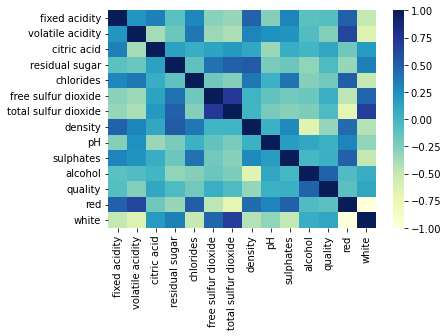

In [54]:
corr = data.corr()

sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,
           cmap="YlGnBu")

# Define Baseline

# Try Linear Model

In [55]:
X=data.drop(['quality'],axis=1)
y=data[['quality']]

In [56]:
lin_model=LinearRegression()

In [57]:
score=cross_val_score(lin_model,X,y)
base_model_score=score.mean()
trained_model=lin_model.fit(X,y)

In [58]:
score

array([0.23467399, 0.29559651, 0.29877781, 0.27309095, 0.29928616])

In [59]:
trained_model.score(X,y)

0.3121448665864082

# Try KNN

In [60]:
knn_model=KNeighborsRegressor()

cv_results=cross_validate(knn_model,X,y,cv=5,
                         scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error'])

In [61]:
pd.DataFrame(cv_results)
base_knn_score=cv_results['test_r2'].mean()
base_knn_score

0.2232889247659453

In [71]:
acc = []
for K in range(2,25):  
    cv_results = cross_validate(knn_model, X, y, cv=K)
    rescaled_score=cv_results['test_score'].mean() 
    acc.append(rescaled_score)

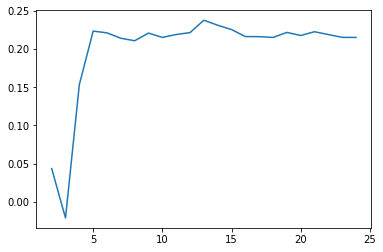

In [70]:
plt.plot(range(2,25),np.array(acc))

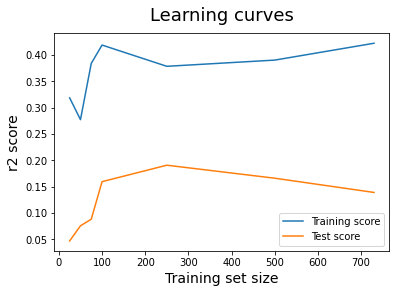

In [75]:
knn = KNeighborsRegressor(n_neighbors = 11)
train_sizes, train_scores, test_scores = learning_curve(estimator = knn,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = [25,50,75,100,250,500,730], 
                                                              cv = 5)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend();